In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.dates as mdates

import pypsa

import logging
from datetime import datetime, timedelta

import pandas as pd
from dateutil import rrule as rr

from assume import World
from assume.common.forecasts import NaiveForecast
from assume.common.market_objects import MarketConfig, MarketProduct

In [2]:
# Time-series data
start, end = '2016-01-13 11:00', '2016-01-13 12:00'
index = pd.date_range(start, end, freq="15min")
prosumer_1_load_ts = pd.Series([5.0, 7.0, 0.0, 3.0, 2.0]) * 10e-3
prosumer_2_load_ts = pd.Series([5.0, 7.0, 0.0, 3.0, 2.0]) * 10e-3
demand_df = pd.concat({"P1": prosumer_1_load_ts, "P2": prosumer_2_load_ts}, axis=1)
demand_df.index = index

In [3]:
# Create a grid where both prosumers are connected via a trafo to a generator.
network = pypsa.Network(snapshots=index)

# LV grid 0.4 kV
network.add("Bus", "LV bus", v_nom=0.4)
network.add("Bus", "Prosumer 1", v_nom=0.4)
network.add("Bus", "Prosumer 2", v_nom=0.4)

network.add("Line", "Feeder 1", bus0="Prosumer 1", bus1="LV bus", type="NAYY 4x150 SE", s_nom=200, length=0.2)
network.add("Line", "Feeder 2", bus0="Prosumer 2", bus1="LV bus", type="NAYY 4x150 SE", s_nom=200, length=0.2)

network.add("Load", name="P1 Load", bus="Prosumer 1", p_set=demand_df["P1"])
network.add("Load", name="P2 Load", bus="Prosumer 2", p_set=demand_df["P2"])

# MV grid 10 kV
network.add("Bus", "MV bus", v_nom=10.0,)
network.add("Bus", "Generator", v_nom=10.0)
network.add("Line", name="MV Line",  bus0="Generator", bus1="MV bus", type="NA2XS2Y 1x240 RM/25 12/20 kV", s_nom=200.0, length=0.2)
generator = network.add("Generator", "Power plant", bus="Generator", control="PQ", p_set=0.1)

# Transformer
network.add("Transformer", "MV/LV", bus0="MV bus", bus1="LV bus", type="0.25 MVA 10/0.4 kV")

Index(['MV/LV'], dtype='object')

In [4]:
# Verify parameters.
network.lpf()  # Note: Lpf will convert single generator to slack generator.
print(network.lines[["bus0", "bus1", "x", "r", "b", "g"]])
print(network.buses[["v_nom", "v_mag_pu_set"]])
print(network.transformers[["bus0", "bus1", "x", "r", "b", "g"]])
print(network.generators[["control", "p_set", "q_set"]])

                bus0    bus1       x       r         b    g
Line                                                       
Feeder 1  Prosumer 1  LV bus  0.0160  0.0416  0.000016  0.0
Feeder 2  Prosumer 2  LV bus  0.0160  0.0416  0.000016  0.0
MV Line    Generator  MV bus  0.0224  0.0244  0.000019  0.0
            v_nom  v_mag_pu_set
Bus                            
LV bus        0.4           1.0
Prosumer 1    0.4           1.0
Prosumer 2    0.4           1.0
MV bus       10.0           1.0
Generator    10.0           1.0
               bus0    bus1         x      r    b       g
Transformer                                              
MV/LV        MV bus  LV bus  0.038158  0.012 -0.0  0.0024
            control  p_set  q_set
Generator                        
Power plant   Slack    0.1    0.0


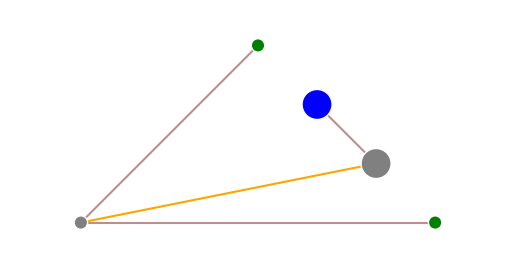

In [5]:
# Verify topology.

# Suppres pypsa deprecation warnings.
logging.getLogger("pypsa").setLevel(logging.ERROR)

# Increase size of MV grid buses and add some colors.
bus_sizes = {b: 0.001 for b in network.buses.index}
bus_colors = {b: "grey" for b in network.buses.index}
bus_sizes["MV bus"], bus_sizes["Generator"] = 0.005, 0.005
bus_colors["Generator"] = "blue"
bus_colors["Prosumer 1"], bus_colors["Prosumer 2"] = "green", "green"
network.plot.map(bus_sizes=bus_sizes, bus_colors=bus_colors, margin=0.2)
plt.show()

In [6]:
# Verify powerflow and export grid.
network.lpf()
network.pf(use_seed=True)
print(network.buses_t["p"])
path_data = Path(".") / "data"
path_grid = path_data / "lv_pv_minimal"
network.generators.to_csv(path_grid / "powerplant_units.csv")
network.loads.to_csv(path_grid / "demand_units.csv")
network.export_to_csv_folder(path_grid)

Bus                  LV bus  Prosumer 1  Prosumer 2  MV bus  Generator
snapshot                                                              
2016-01-13 11:00:00     0.0       -0.05       -0.05     0.0   0.102449
2016-01-13 11:15:00     0.0       -0.07       -0.07     0.0   0.144283
2016-01-13 11:30:00     0.0        0.00        0.00     0.0   0.000600
2016-01-13 11:45:00     0.0       -0.03       -0.03     0.0   0.061256
2016-01-13 12:00:00     0.0       -0.02       -0.02     0.0   0.040889


In [7]:
log = logging.getLogger(__name__)

db_uri = "sqlite:///local_db/assume_db.db"

world = World(database_uri=db_uri, export_csv_path=path_data)

start = datetime(2023, 1, 13)
end = datetime(2023, 1, 15)
# index = pd.date_range(start=start, end=end, freq="15min")
index = pd.date_range(start, end, freq="15min")
simulation_id = "world_script_simulation"

world.setup(
    start=start,
    end=end,
    save_frequency_hours=1,
    simulation_id=simulation_id,
    index=index,
)

INFO:assume.world:Connected to the database
INFO:assume.world:Learning Strategies are not available. Check that you have torch installed.


In [8]:
# Create a simple market.
market_config = MarketConfig(
    market_id="EOM",
    opening_hours=rr.rrule(rr.HOURLY, interval=1, dtstart=start, until=end),
    opening_duration=timedelta(hours=1),
    market_mechanism="pay_as_clear",
    market_products=[MarketProduct(timedelta(minutes=15), 24, timedelta(minutes=15))],
    additional_fields=["block_id", "link", "exclusive_id"])

mo_id = "market_operator"
world.add_market_operator(id=mo_id)

world.add_market(market_operator_id=mo_id, market_config=market_config)

In [9]:
# Create consumers.
for i in range(2):
    # Each household has a constant load of 10 kW
    demand = pd.Series(index=index, data=len(index) * [0.01])
    demand_forecast = NaiveForecast(index, demand=demand)
    world.add_unit_operator(f"demand_operator_{i}")

    world.add_unit(
        id=f"demand_unit_{i}",
        unit_type="demand",
        unit_operator_id=f"demand_operator_{i}",
        unit_params={
            "min_power": 0,
            "max_power": 1000,
            "bidding_strategies": {"EOM": "naive_eom"},
            "technology": "demand",
            "price": 2.5 + i,
        },
        forecaster=demand_forecast)

In [10]:
for i in range(1):
    world.add_unit_operator(f"plant_operator_{i}")
    
    nuclear_forecast = NaiveForecast(index, availability=1, fuel_price=2.5 + i)
    
    world.add_unit(
        id=f"nucular_unit_{i}",
        unit_type="power_plant",
        unit_operator_id=f"plant_operator_{i}",
        unit_params={
            "min_power": 0.000,
            "max_power": 0.015,
            "bidding_strategies": {"EOM": "naive_eom"},
            "technology": "nuclear",
        },
        forecaster=nuclear_forecast,
    )

In [11]:
world.run()

world_script_simulation 2023-01-15 00:00:00: : 172801.0it [00:02, 83203.33it/s]                          


In [12]:
# Plot order data.
market_orders = pd.read_csv(path_data / "world_script_simulation" / "market_orders.csv")
market_orders

start_time             end_time  price  volume   node  \
0     2023-01-13 00:15:00  2023-01-13 00:30:00    2.5  -0.010  node0   
1     2023-01-13 00:30:00  2023-01-13 00:45:00    2.5  -0.010  node0   
2     2023-01-13 00:45:00  2023-01-13 01:00:00    2.5  -0.010  node0   
3     2023-01-13 01:00:00  2023-01-13 01:15:00    2.5  -0.010  node0   
4     2023-01-13 01:15:00  2023-01-13 01:30:00    2.5  -0.010  node0   
...                   ...                  ...    ...     ...    ...   
1379  2023-01-14 21:00:00  2023-01-14 21:15:00    2.5  -0.005  node0   
1380  2023-01-14 21:15:00  2023-01-14 21:30:00    2.5  -0.005  node0   
1381  2023-01-14 21:30:00  2023-01-14 21:45:00    2.5  -0.005  node0   
1382  2023-01-14 21:45:00  2023-01-14 22:00:00    2.5  -0.005  node0   
1383  2023-01-14 22:00:00  2023-01-14 22:15:00    2.5  -0.005  node0   

      block_id  link  exclusive_id            bid_id        unit_id  \
0          NaN   NaN           NaN   demand_unit_0_1  demand_unit_0   
1          NaN   NaN           NaN   demand_unit_0_2  demand_unit_0   
2          NaN   NaN           NaN   demand_unit_0_3  demand_unit_0   
3          NaN   NaN           NaN   demand_unit_0_4  demand_unit_0   
4          NaN   NaN           NaN   demand_unit_0_5  demand_unit_0   
...        ...   ...           ...               ...            ...   
1379       NaN   NaN           NaN  demand_unit_0_16  demand_unit_0   
1380       NaN   NaN           NaN  demand_unit_0_17  demand_unit_0   
1381       NaN   NaN           NaN  demand_unit_0_18  demand_unit_0   
1382       NaN   NaN           NaN  demand_unit_0_19  demand_unit_0   
1383       NaN   NaN           NaN  demand_unit_0_20  demand_unit_0   

      accepted_volume  accepted_price market_id  bid_type  \
0              -0.005             2.5       EOM       NaN   
1              -0.005             2.5       EOM       NaN   
2              -0.005             2.5       EOM       NaN   
3              -0.005             2.5       EOM       NaN   
4              -0.005             2.5       EOM       NaN   
...               ...             ...       ...       ...   
1379            0.000             2.5       EOM       NaN   
1380            0.000             2.5       EOM       NaN   
1381            0.000             2.5       EOM       NaN   
1382            0.000             2.5       EOM       NaN   
1383            0.000             2.5       EOM       NaN   

                   simulation  
0     world_script_simulation  
1     world_script_simulation  
2     world_script_simulation  
3     world_script_simulation  
4     world_script_simulation  
...                       ...  
1379  world_script_simulation  
1380  world_script_simulation  
1381  world_script_simulation  
1382  world_script_simulation  
1383  world_script_simulation  

[1384 rows x 15 columns]

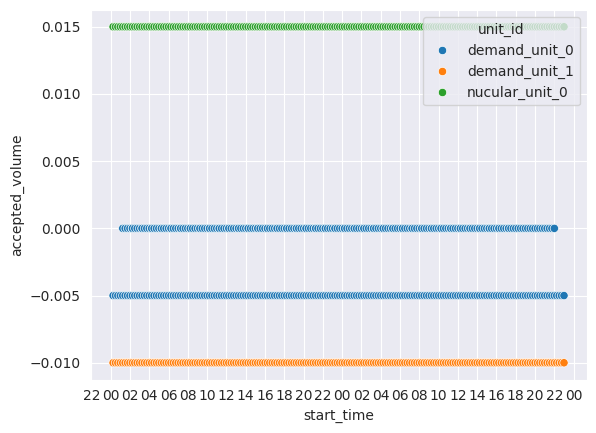

In [13]:
x = pd.DatetimeIndex(market_orders["start_time"])

ax = sns.scatterplot(market_orders, x=x, y="accepted_volume", hue="unit_id")

ax.xaxis.set_major_locator(mdates.HourLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H'))

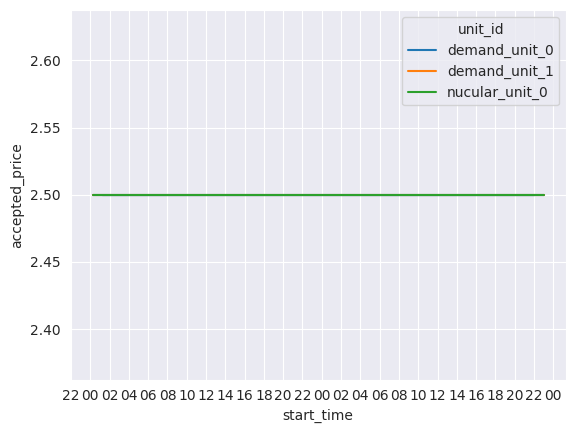

In [14]:
ax = sns.lineplot(market_orders, x=x, y="accepted_price", hue="unit_id")

ax.xaxis.set_major_locator(mdates.HourLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H'))

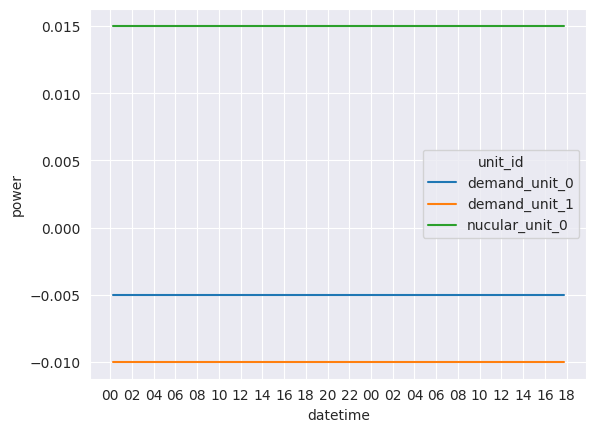

In [15]:
# Plot Market Dispatch
market_dispatch = pd.read_csv(path_data / "world_script_simulation" / "market_dispatch.csv")
x = pd.DatetimeIndex(market_dispatch["datetime"])
ax = sns.lineplot(market_dispatch, x=x, y="power", hue="unit_id")

ax.xaxis.set_major_locator(mdates.HourLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H'))